In [1]:
import pandas as pd
import utils
import numpy as np
import plotly.express as px

np.random.seed(9000)


In this notebook we calculate `mean average precision` to compare the different experimental conditions. The following are the steps taken
1. Normalized, feature selected ORF, CRISPR and Compound profiles are read and the replicate plates are merged into a single dataframe, for each time point and cell line.
2. Negons and empty wells are removed from the dataframe.
3. Average precision (AP) is computed for each replicate of each perturbation to the task of retrieving replicates against other perturbations. Mean average precision (mAP) is computed for each perturbation.
4. The AP of a random classifier is subtracted from each perturbation's AP.
5. Table of AP values is printed and bar plot of AP is plotted.

In [2]:
precision_df = pd.DataFrame()
group_by_feature = 'Metadata_broad_sample'
batch = "2020_11_04_CPJUMP1"
all_percent_perturbation_df = pd.DataFrame()

experiment_df = (
    pd.read_csv('output/experiment-metadata.tsv', sep='\t')
    .query('Batch==@batch')
    .query('Density=="100"')
    .query('Antibiotics=="absent"')
)

experiment_df.drop(experiment_df[(experiment_df.Perturbation == "compound") & (experiment_df.Cell_line == "Cas9")].index, inplace=True)

In [3]:
for modality in experiment_df.Perturbation.unique():
    modality_df = experiment_df.query("Perturbation==@modality")
    for cell in modality_df.Cell_type.unique():
        cell_df = modality_df.query('Cell_type==@cell')
        for time_point in cell_df.Time.unique():
            time_df = cell_df.query("Time==@time_point")
            all_plates_df = pd.DataFrame()
            for plate in time_df.Assay_Plate_Barcode.unique():
                data_df = utils.load_data(batch, plate, "normalized_feature_select_negcon_batch.csv.gz")
                all_plates_df = utils.concat_profiles(all_plates_df, data_df)

            all_plates_df = utils.remove_negcon_empty_wells(all_plates_df)

            score = utils.PrecisionScores(all_plates_df, all_plates_df, group_by_feature, within=True)

            precision_df = precision_df.append({'Description':f'{modality}_{cell}_{time_point}',
                                                'Modality':f'{modality}',
                                                'Cell':f'{cell}',
                                                'time':f'{time_point}',
                                                'mAP':f'{score.map:.3f}'}, ignore_index=True)


In [4]:
print(precision_df[['Description', 'mAP']].to_markdown(index=False))

| Description      |   mAP |
|:-----------------|------:|
| compound_A549_24 | 0.374 |
| compound_A549_48 | 0.569 |
| compound_U2OS_24 | 0.389 |
| compound_U2OS_48 | 0.329 |
| crispr_U2OS_144  | 0.061 |
| crispr_U2OS_96   | 0.127 |
| crispr_A549_144  | 0.057 |
| crispr_A549_96   | 0.066 |
| orf_A549_96      | 0.047 |
| orf_A549_48      | 0.052 |
| orf_U2OS_48      | 0.153 |
| orf_U2OS_96      | 0.09  |


In [5]:
precision_df['mAP'] = precision_df['mAP'].astype(float)

precision_df.loc[(precision_df.Modality=='compound') & (precision_df.time=='24'), 'time'] = 'short'
precision_df.loc[(precision_df.Modality=='compound') & (precision_df.time=='48'), 'time'] = 'long'
precision_df.loc[(precision_df.Modality=='crispr') & (precision_df.time=='96'), 'time'] = 'short'
precision_df.loc[(precision_df.Modality=='crispr') & (precision_df.time=='144'), 'time'] = 'long'
precision_df.loc[(precision_df.Modality=='orf') & (precision_df.time=='48'), 'time'] = 'short'
precision_df.loc[(precision_df.Modality=='orf') & (precision_df.time=='96'), 'time'] = 'long'

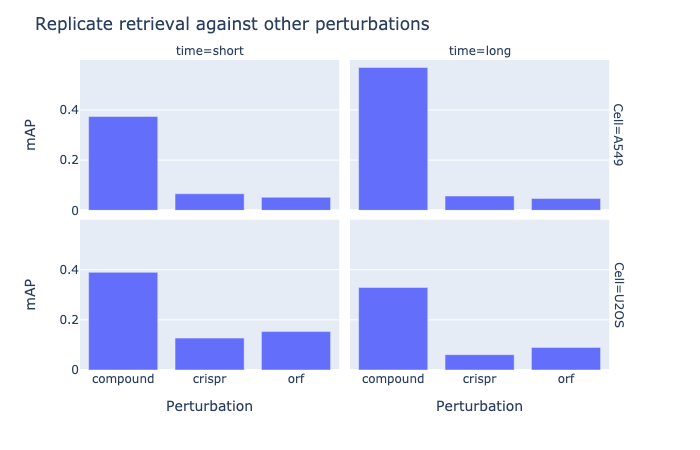

In [6]:
fig = px.bar(data_frame=precision_df,
             x='Modality',
             y='mAP',
             facet_row='Cell',
             facet_col='time')
fig.update_layout(title='Replicate retrieval against other perturbations',
                  xaxis1=dict(title='Perturbation'),
                  xaxis2=dict(title='Perturbation'),
                  yaxis=dict(title='mAP'),
                  yaxis3=dict(title='mAP'))
fig.show("png")
fig.write_image(f'figures/1.mAP_CellProfiler.png', width=640, height=480, scale=2)

In [7]:
precision_df[['Modality','Cell','time','mAP']].to_csv('output/cellprofiler_precision_score.csv', index=False)